In [1]:
import numpy as np
"""from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive/YYY_deep_project_YYY'
!ls"""


"from google.colab import drive\ndrive.mount('/content/drive')\n%cd drive/'My Drive/YYY_deep_project_YYY'\n!ls"

In [2]:
def get_sequence(infile):

    while True:

        header = infile.readline()
        sequence = infile.readline()

        pdb = header[1:5]

        if not header or not sequence or set(sequence) == {'X'}:
            return
        
        yield header.strip()[1:], sequence.strip(), pdb

10000


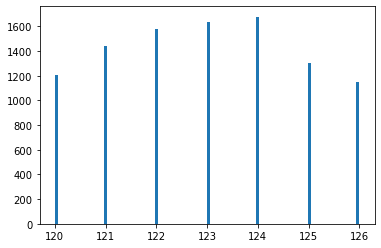

In [3]:
sequences = []
seq_to_pdb = {}
count = 0
with open('data/sra100k_done.fa') as infile:
#with open('data/all_heavy.fasta') as infile:
        for header, sequence, pdb in get_sequence(infile):
            sequences.append(list(sequence))
            seq_to_pdb[sequence] = pdb

#sequences = list(filter(lambda x:len(x)<150, sequences))

import random
random.shuffle(sequences)

sequences = [seq for seq in sequences if len(seq) >= 120 and len(seq) <= 126]
sequences = sequences[:10000]

import matplotlib.pyplot as plt
lengths = [len(seq) for seq in sequences]
max_len = max(lengths)+2 # plus two for sos and eos
print(len(sequences))

plt.hist(lengths, bins=100)
plt.show()


In [4]:
from torch.utils import data
from random import shuffle


class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    
    
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)
    
    print(num_train, num_val, num_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]

    # add reversed sequences for training and shuffle
    #sequences_train += [seq[::-1] for seq in sequences_train]
    #shuffle(sequences_train)

    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[num_train+num_val:]

    input_train = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_train]
    input_val = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_val]
    input_test = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_test]

    return (input_train, input_val, input_test)

(input_train, input_val, input_test) = create_datasets(sequences, Dataset)

len(input_train), len(input_val), len(input_test)

8000 1000 1000


(8000, 1000, 1000)

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.cuda.empty_cache()


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        
        self.model_type = 'Transformer'
        
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        
        self.t_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        self.embed = nn.Embedding(ntoken, ninp)
        self.ninp = ninp

        decoder_layers = TransformerDecoderLayer(ninp, nhead, ntoken, dropout)
        
        self.t_decoder = TransformerDecoder(decoder_layers, nlayers)
        
        self.ff = nn.Linear(ninp, ntoken)
        
        self._init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float(-1e-10)).masked_fill(mask == 1, float(0.0))
        
        return mask

 
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
       

    def forward(self, src, src_mask, tgt, tgt_mask): #src_pad_mask, tgt_pad_mask, mem_pad_mask=None):
        

        embeds = self.embed(src) * math.sqrt(self.ninp)
        
        positions = self.pos_encoder(embeds)
    
        
        encoded = self.t_encoder(positions)
        #encoded = self.t_encoder(positions, src_key_padding_mask=src_pad_mask)
        
        
        #if mem_pad_mask is None:
        #    mem_pad_mask = tgt_pad_mask.clone()
            
        embeds = self.embed(tgt) * math.sqrt(self.ninp)
        
        positions = self.pos_encoder(embeds)
        
        #decoded = self.t_decoder(tgt=positions, memory=encoded, tgt_mask=tgt_mask,
        #                         tgt_key_padding_mask=tgt_pad_mask,
        #                         memory_key_padding_mask=mem_pad_mask)
        
        decoded = self.t_decoder(tgt=positions, memory=encoded, tgt_mask=tgt_mask)

        output = self.ff(decoded)
        #output = repetition_penalty(output)
        
        return output


In [6]:
vocab = ['<pad>', "<sos>", "<eos>"] + ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","X","Y"]
char_nums = {token:vocab.index(token) for token in vocab}

def batchify(data):
    # get the length of each seq in your batch
    seq_lengths = torch.LongTensor([len(seq) for seq in data])

    train_vectorized = [[char_nums[char] for char in seq] for seq in data]
    sources = [seq[:-1] for seq in train_vectorized]
    targets = [seq[1:] for seq in train_vectorized]
    
    # dump padding everywhere, and place seqs on the left.
    # NOTE: you only need a tensor as big as your longest sequence
    src_tensor = torch.zeros((len(train_vectorized), seq_lengths.max()-1)).long()
    tgt_tensor = torch.zeros((len(train_vectorized), seq_lengths.max()-1)).long()

    
    for idx, (seq, seqlen) in enumerate(zip(sources, seq_lengths)):
        src_tensor[idx, :(seqlen-1)] = torch.LongTensor(seq)
    
    for idx, (seq, seqlen) in enumerate(zip(targets, seq_lengths)):
        tgt_tensor[idx, :(seqlen-1)] = torch.LongTensor(seq)
        
        
    # SORT YOUR TENSORS BY LENGTH!
    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    
    src_tensor = src_tensor[perm_idx]
    tgt_tensor = tgt_tensor[perm_idx]

    return src_tensor, tgt_tensor


train_src, train_tgt = batchify(input_train)
val_src, val_tgt = batchify(input_val)
test_src, test_tgt = batchify(input_test)

In [7]:
bptt = 100

def get_batch(sources, targets, idx):
    n_seqs = min(bptt, len(sources) - idx)
    
    max_len = max([len(seq) for seq in sources])
    
    src = torch.cat([sources[i] for i in range(idx, n_seqs+idx)]).view(n_seqs, max_len)
        
    target = torch.cat([targets[i] for i in range(idx, n_seqs+idx)]).view(n_seqs, max_len)#.reshape(-1)
    
    return src, target



In [8]:
ntokens = len(vocab) # the size of vocabulary
emsize = max_len # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 6 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8 # the number of heads in the multiheadattention models
dropout = 0 # the dropout value


In [28]:
def repetition_penalty(output, device='cuda'):
    # convert to cpu memory to use numpy
    out = output.clone()
    
    with torch.no_grad():
        out = np.array(out.cpu())
        for seq_idx in range(out.shape[0]):            
            for pos_idx in range(len(out[seq_idx])):
                if pos_idx > 3:
                    # get mean of each aa prob for the last four positions in sequence
                    last_4 = np.array(out[seq_idx][pos_idx-4:pos_idx])
                    mean_last_4 = np.mean(last_4, axis=0)
                    # subtract half the mean from real output
                    out[seq_idx][pos_idx] -= 0.5*mean_last_4
                elif pos_idx != 0:
                    last_n = np.array(out[seq_idx][0:pos_idx])
                    mean_last_n = np.mean(last_n, axis=0)
                    out[seq_idx][pos_idx] -= 0.5*mean_last_n
    for seq_idx in range(out.shape[0]):            
          for pos_idx in range(len(out[seq_idx])):
              for aa_idx in range(len(out[seq_idx][pos_idx])):
                  output[seq_idx][pos_idx][aa_idx] = float(out[seq_idx][pos_idx][aa_idx])

    # return softmaxed probs
    return F.softmax(output)

In [35]:
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nums2chars = {val: key for key, val in char_nums.items()}
#  ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 0.01 # learning rate, SGD
#lr = 0.00004 # learning rate, Adam
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
#optimizer  = torch.optim.Adam(lr=lr, params=model.parameters(), weight_decay=0.2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

train_losses = []
val_losses = []
import sys
import time
def train():
    
    train_loss = 0
    n_batches = 0
    
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    for batch, i in enumerate(range(0, train_src.size(0) - 1, bptt)):
        
        data, targets = get_batch(train_src, train_tgt, i)
    
        data, targets = data.to(device), targets.to(device)
        #print(i)
        #print('Data:')
        #print([nums2chars[int(num)] for num in data[0]])
        #print('Targets:')
        #print([nums2chars[int(num)] for num in targets[0]])
        targets = targets.view(data.shape)
        
        optimizer.zero_grad()
        
            
        src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        #src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
        tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
        #tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))
        
        output = model(data, src_mask, targets, tgt_mask)#, src_pad_mask, tgt_pad_mask)
        #output = repetition_penalty(output).to(device)

        output_trans = output.view(-1, ntokens)
        #target_trans = targets.view(-1, targets.size(0) * targets.size(1)).squeeze(0)
        target_trans = targets.view(-1)
        loss = criterion(output_trans, target_trans)
        
        n_batches += 1
        train_loss += loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        
        # Soft, hard accuracy
        #o = list(output.view(-1, ntokens)[0])
        #t = targets
        #print(o,t)
        #hard_acc = sum([i for i in range(len(targets)) if o[i] == t[i]])/len(targets)
        
        optimizer.step()
        
        total_loss += loss.item()
        log_interval = 10
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.8f} | ms/batch {:5.2f} | '
                  'loss {:5.5f} | ppl {:8.5f}|'.format(
                    epoch, batch, len(train_src) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    
    train_losses.append(train_loss/n_batches)
    

def evaluate(eval_model, src, tgt):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    
    with torch.no_grad():
        for idx in range(0, src.size(0) - 1, bptt):
            data, targets = get_batch(src, tgt, idx)
            data, targets = data.to(device), targets.to(device)
            
            targets = targets.view(data.shape)
            
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            #src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
            tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
            #tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))    
            
            output = eval_model(data, src_mask, targets, tgt_mask)#, src_pad_mask, tgt_pad_mask)
            #output = aa_penalty(output).to(device)

            output_trans = output.view(-1, ntokens)
            #target_trans = targets.view(-1, targets.size(1) * targets.size(0)).squeeze(0)
            target_trans = targets.view(-1)
            
            total_loss += len(data) * criterion(output_trans, target_trans).item()
            
    return total_loss / (len(src) - 1)


In [36]:
best_val_loss = float("inf")
epochs = 200 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_src, val_tgt)
    val_losses.append(val_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.8f} | '
          'valid ppl {:8.5f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |    10/   80 batches | lr 0.01000000 | ms/batch 298.27 | loss 4.22282 | ppl 68.22537|
| epoch   1 |    20/   80 batches | lr 0.01000000 | ms/batch 258.46 | loss 3.22186 | ppl 25.07482|
| epoch   1 |    30/   80 batches | lr 0.01000000 | ms/batch 257.36 | loss 2.89662 | ppl 18.11285|
| epoch   1 |    40/   80 batches | lr 0.01000000 | ms/batch 257.96 | loss 2.67997 | ppl 14.58471|
| epoch   1 |    50/   80 batches | lr 0.01000000 | ms/batch 258.76 | loss 2.50518 | ppl 12.24575|
| epoch   1 |    60/   80 batches | lr 0.01000000 | ms/batch 253.66 | loss 2.32995 | ppl 10.27747|
| epoch   1 |    70/   80 batches | lr 0.01000000 | ms/batch 258.06 | loss 2.12947 | ppl  8.41039|
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 21.59s | valid loss 1.85387674 | valid ppl  6.38452
-----------------------------------------------------------------------------------------
| epoch   2 |    10/   80 batches | lr 0.0098010

| epoch   9 |    70/   80 batches | lr 0.00913517 | ms/batch 255.96 | loss 0.00634 | ppl  1.00636|
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 21.21s | valid loss 0.00745637 | valid ppl  1.00748
-----------------------------------------------------------------------------------------
| epoch  10 |    10/   80 batches | lr 0.00904382 | ms/batch 279.26 | loss 0.00662 | ppl  1.00665|
| epoch  10 |    20/   80 batches | lr 0.00904382 | ms/batch 257.16 | loss 0.00562 | ppl  1.00564|
| epoch  10 |    30/   80 batches | lr 0.00904382 | ms/batch 250.26 | loss 0.00537 | ppl  1.00539|
| epoch  10 |    40/   80 batches | lr 0.00904382 | ms/batch 255.76 | loss 0.00522 | ppl  1.00523|
| epoch  10 |    50/   80 batches | lr 0.00904382 | ms/batch 254.46 | loss 0.00505 | ppl  1.00506|
| epoch  10 |    60/   80 batches | lr 0.00904382 | ms/batch 253.76 | loss 0.00504 | ppl  1.00505|
| epoch  10 |    70/   80 batches | lr 0.0090438

| epoch  18 |    40/   80 batches | lr 0.00834514 | ms/batch 255.76 | loss 0.00194 | ppl  1.00194|
| epoch  18 |    50/   80 batches | lr 0.00834514 | ms/batch 256.16 | loss 0.00190 | ppl  1.00190|
| epoch  18 |    60/   80 batches | lr 0.00834514 | ms/batch 256.86 | loss 0.00192 | ppl  1.00193|
| epoch  18 |    70/   80 batches | lr 0.00834514 | ms/batch 254.96 | loss 0.00197 | ppl  1.00197|
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 21.23s | valid loss 0.00320311 | valid ppl  1.00321
-----------------------------------------------------------------------------------------
| epoch  19 |    10/   80 batches | lr 0.00826169 | ms/batch 274.06 | loss 0.00214 | ppl  1.00214|
| epoch  19 |    20/   80 batches | lr 0.00826169 | ms/batch 253.86 | loss 0.00186 | ppl  1.00186|
| epoch  19 |    30/   80 batches | lr 0.00826169 | ms/batch 257.46 | loss 0.00182 | ppl  1.00182|
| epoch  19 |    40/   80 batches | lr 0.0082616

| epoch  27 |    10/   80 batches | lr 0.00762343 | ms/batch 274.36 | loss 0.00137 | ppl  1.00137|
| epoch  27 |    20/   80 batches | lr 0.00762343 | ms/batch 256.76 | loss 0.00120 | ppl  1.00120|
| epoch  27 |    30/   80 batches | lr 0.00762343 | ms/batch 255.46 | loss 0.00118 | ppl  1.00118|
| epoch  27 |    40/   80 batches | lr 0.00762343 | ms/batch 256.86 | loss 0.00117 | ppl  1.00118|
| epoch  27 |    50/   80 batches | lr 0.00762343 | ms/batch 254.26 | loss 0.00115 | ppl  1.00115|
| epoch  27 |    60/   80 batches | lr 0.00762343 | ms/batch 254.06 | loss 0.00117 | ppl  1.00117|
| epoch  27 |    70/   80 batches | lr 0.00762343 | ms/batch 248.76 | loss 0.00120 | ppl  1.00120|
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 21.15s | valid loss 0.00241551 | valid ppl  1.00242
-----------------------------------------------------------------------------------------
| epoch  28 |    10/   80 batches | lr 0.0075471

KeyboardInterrupt: 

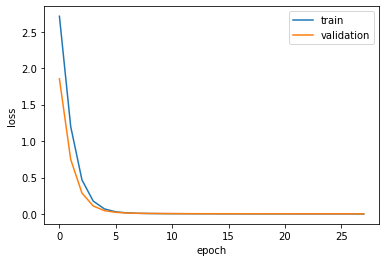

In [37]:
#torch.save(model, "model_bad_1.py")

plt.figure()

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


In [13]:
# save losses for plotting
#import pandas as pd
#df = pd.DataFrame({'train_loss':[float(l) for l in train_losses], 'val_loss': val_losses})
#df.to_csv('model_bad_1_losses.tsv', sep='\t', index=False)

In [38]:
eval_model = best_model

test_loss = evaluate(best_model, test_src, test_tgt)
print('=' * 89)
print('| End of training | test loss {:5.10f} | test ppl {:8.10f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

print("Last validation loss: {}".format(val_losses[-1]))

| End of training | test loss 0.0020221459 | test ppl 1.0020241918
Last validation loss: 0.0023642397794249774


In [39]:
idx_to_letter = {val:key for key, val in char_nums.items()}

def batchify_for_seq_sampling(data):
    # get the length of each seq in your batch
    seq_lengths = torch.LongTensor([len(seq) for seq in data])
    train_vectorized = [[char_nums[char] for char in seq] for seq in data]

    # dump padding everywhere, and place seqs on the left.
    # NOTE: you only need a tensor as big as your longest sequence
    src_tensor = torch.zeros((len(train_vectorized), seq_lengths.max())).long()
    tgt_tensor = torch.zeros((len(train_vectorized), seq_lengths.max())).long()

    for idx, (seq, seqlen) in enumerate(zip(train_vectorized, seq_lengths)):
        src_tensor[idx, :(seqlen)] = torch.LongTensor(seq)

    return src_tensor, tgt_tensor

import pdb
def sample_categorical(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome log-probabilities
    :param temperature: Sampling temperature. 1.0 follows the given distribution,
        0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """
    #pdb.set_trace()
    #print('-'*50)
    #print(lnprobs.shape) # fratraek lnprobs(forrige_aa) med 1.2 gange sig selv
    #print(lnprobs)
    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature)#, dim=1)
    
    #print("softmaxed probs:", p)
    sample = dist.Categorical(p).sample()
    
    #lnprobs=lnprobs.squeeze().div(temperature).exp()
    #sample = torch.multinomial(lnprobs, 1)[0]
    
    #print('sample:',sample)
    return sample

def sample_sentence(model, query, max_len = 126, min_len=120, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while len(query) < max_len and '<eos>' not in query:
        data, targets = batchify_for_seq_sampling([query])
        data, targets = data.to(device), targets.to(device)
    
        src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        #src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
        tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
        #tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))   
        
        output = eval_model(data, src_mask, targets, tgt_mask).view(-1, ntokens)#src_pad_mask, tgt_pad_mask
        
        next_char_idx = sample_categorical(output[-1], 0.5)
        
        # dont add <pad> or <sos>
        if next_char_idx == 0 or next_char_idx == 1: continue
        # dont add eos if less than min length
        elif next_char_idx == 2 and len(query) < min_len: continue

        try:
            query += [idx_to_letter[int(next_char_idx)]]
        except IndexError:
            query += [idx_to_letter[int(next_char_idx)]]
            
    return query


In [40]:
import torch.distributions as dist
for _ in range(10):
    with torch.no_grad():
        sample = sample_sentence(model, ['<sos>'], max_len = 150, temperature=1)

        print(len(sample), " ".join(sample))


<ipython-input-39-25a8e5653eb6>:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(lnprobs / temperature)#, dim=1)


KeyboardInterrupt: 

[('in_proj_weight', torch.Size([384, 128])), ('in_proj_bias', torch.Size([384])), ('out_proj.weight', torch.Size([128, 128])), ('out_proj.bias', torch.Size([128])), ('weight', torch.Size([128, 128])), ('bias', torch.Size([128]))]


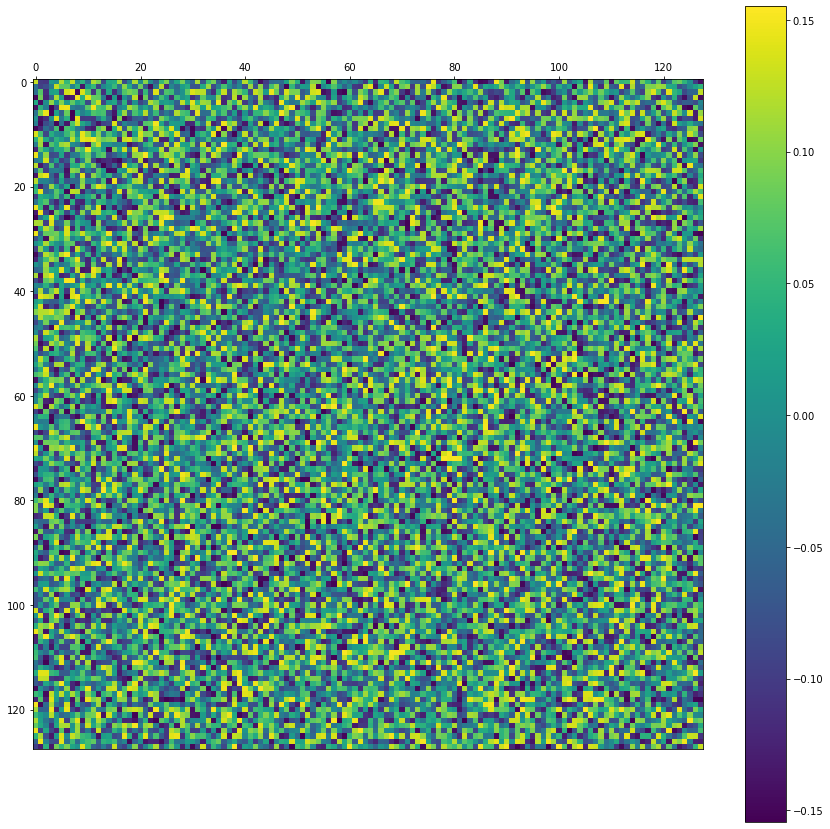

In [41]:
weights = []
for m in eval_model.t_encoder.layers[0].self_attn.modules():
    
    for p in m.named_parameters():
        
        weights.append(p)
        
print([(w[0],w[1].shape) for w in weights])
w = weights[2][1]

fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(w.detach().cpu().numpy())
ax.xaxis.tick_top()
plt.colorbar()
plt.show()

In [42]:
model = torch.load("../results/model_bad_1.py")

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (t_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=200, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=200, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=20

[('in_proj_weight', torch.Size([384, 128])), ('in_proj_bias', torch.Size([384])), ('out_proj.weight', torch.Size([128, 128])), ('out_proj.bias', torch.Size([128])), ('weight', torch.Size([128, 128])), ('bias', torch.Size([128]))]


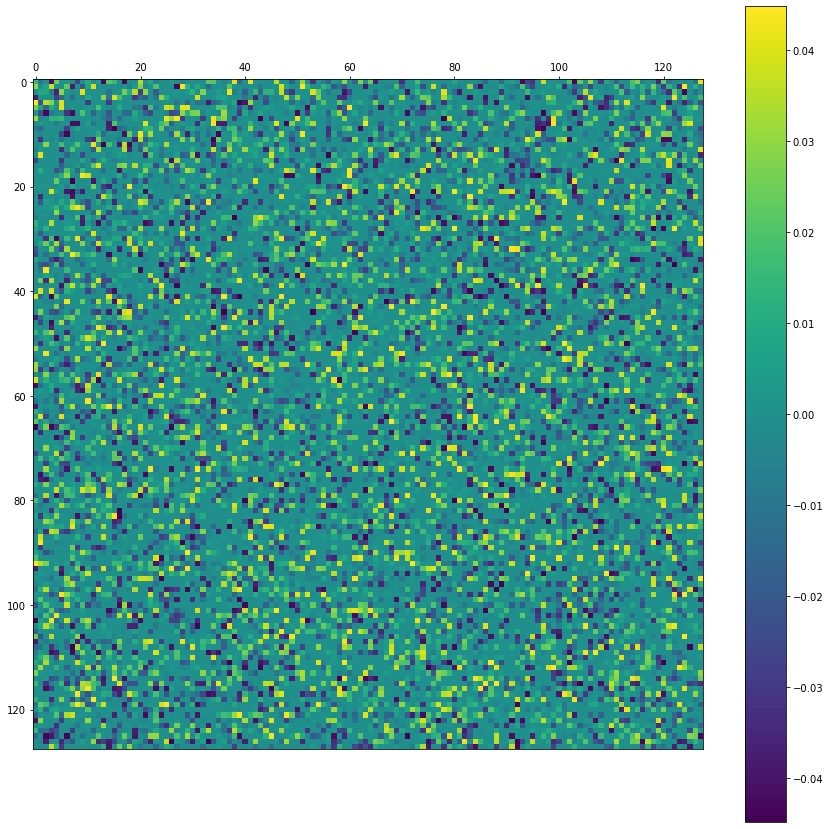

In [45]:
weights = []
for m in model.t_encoder.layers[0].self_attn.modules():
    
    for p in m.named_parameters():
        
        weights.append(p)
        
print([(w[0],w[1].shape) for w in weights])
w = weights[2][1]

fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(w.detach().cpu().numpy())
ax.xaxis.tick_top()
plt.colorbar()
plt.show()

In [20]:
mod = torch.load("../results/model_bad_1.py")

In [84]:
bptt = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data, targets = get_batch(train_src, train_tgt, 0)
    
data, targets = data.to(device), targets.to(device)

targets = targets.view(data.shape)


src_mask = mod.generate_square_subsequent_mask(data.size(0)).to(device)
#src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))

tgt_mask = mod.generate_square_subsequent_mask(targets.size(0)).to(device)
#tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))

output = mod(data, src_mask, targets, tgt_mask)#, src_pad_mask, tgt_pad_mask)

output

tensor([[[-0.2533, -0.5017, -0.4395,  ..., -0.4791, -0.2416, -0.1189],
         [-0.1783, -0.0743, -0.6466,  ..., -0.3345, -0.5431,  0.1787],
         [-0.4816, -0.6255, -0.6287,  ..., -0.0529, -0.6716,  0.0981],
         ...,
         [-0.4721, -0.6288, -0.6386,  ..., -0.0559, -0.6620,  0.0982],
         [-0.2538, -0.5000, -0.4301,  ..., -0.4870, -0.2514, -0.1198],
         [-0.4908, -0.5945, -0.6444,  ...,  0.0792,  0.3189,  0.3918]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [68]:
data[0]

tensor([ 1,  8,  6, 18, 12, 11, 10, 18,  4,  3,  3, 18,  8,  7, 19,  7, 18, 10,
        23,  3, 13, 18, 21, 20, 17, 16,  3, 15,  8, 11,  8, 12,  6, 21, 20, 18,
         8, 10, 18,  8, 18,  8,  8, 18, 19, 14, 23,  3,  6, 18, 20, 11,  8, 17,
         7, 19, 10, 18, 17,  5, 14, 18, 11, 18, 19, 12, 18, 12, 16, 13, 14, 18,
        12, 17,  3,  6,  5, 19,  3, 20, 23, 23,  4,  3, 11,  5, 16,  8, 12, 19,
         8, 15, 17,  8,  5, 23, 20, 18, 23, 20,  8, 23, 21,  8, 16,  8, 19, 12,
        20, 19, 20, 18, 18,  3, 15, 19, 11,  3, 15,  5, 20,  7, 15, 10, 10, 18,
         8], device='cuda:0')

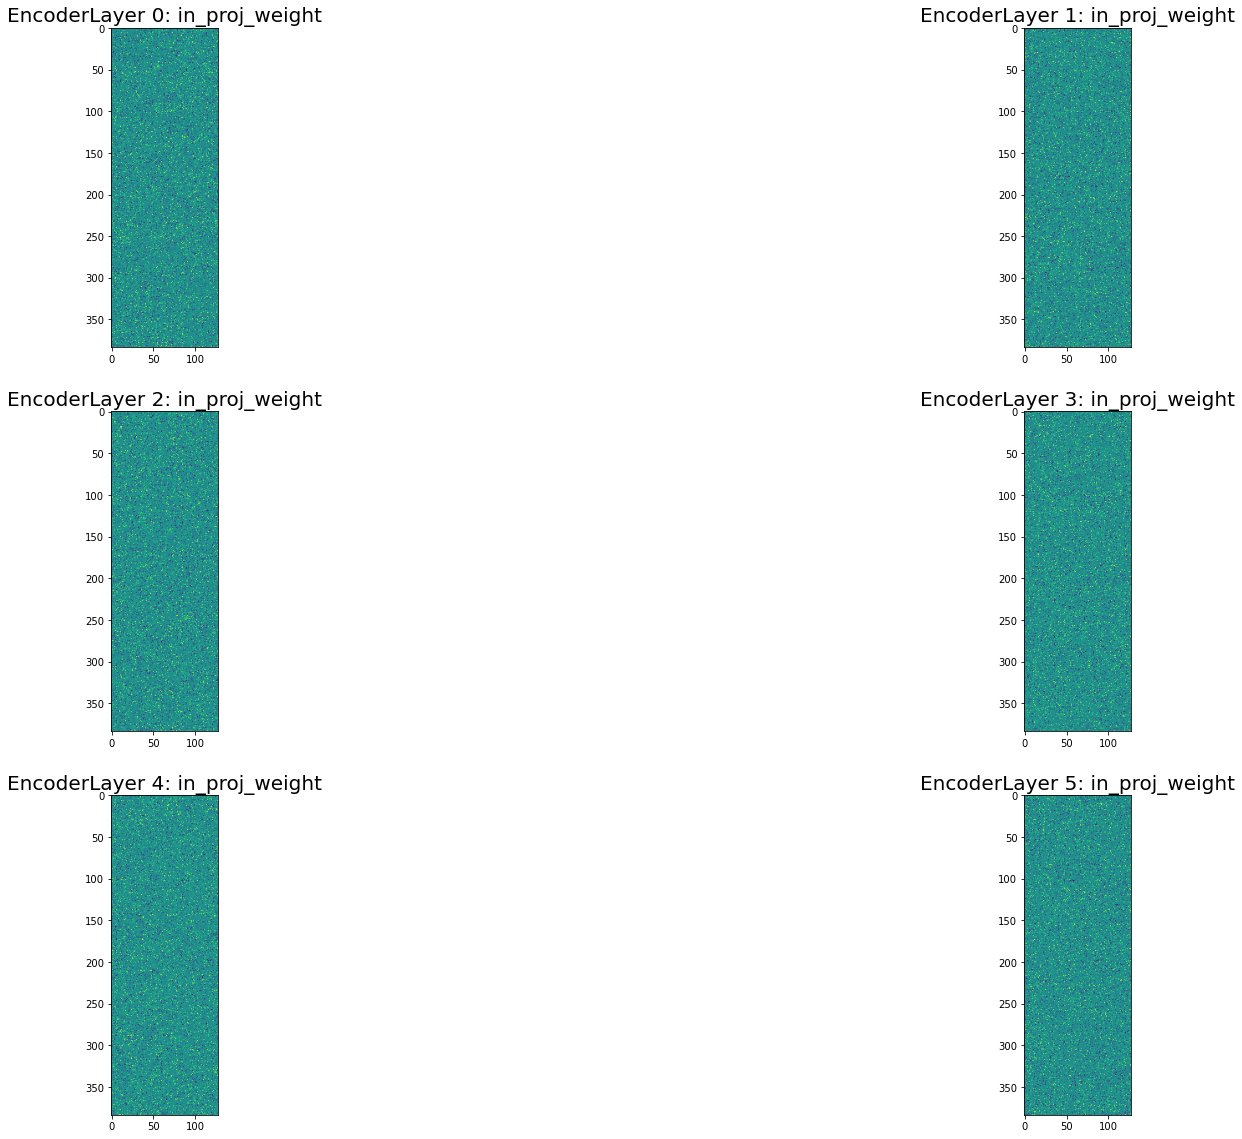

In [95]:
fig, ax = plt.subplots(3,2, figsize=(30,20))

x = [0,0,1,1,2,2]
y = [0,1,0,1,0,1]

for i, (x,y) in enumerate(zip(x,y)):

    weights = []
    for m in mod.t_encoder.layers[i].self_attn.modules():
    
        for p in m.named_parameters():

            weights.append(p)

    #print([(w[0],w[1].shape) for w in weights])
    w = weights[0][1]
    #print(weights[2][0])

    ax[x][y].imshow(w.detach().cpu().numpy())
    #plt.xaxis.tick_top()
    ax[x][y].set_title(f"EncoderLayer {i}: {weights[0][0]}", fontsize=20)

#plt.tight_layout()
plt.show()
#plt.savefig("model_bad_1_att.pdf")

In [33]:
len(mod.t_encoder.layers)

6

[('in_proj_weight', torch.Size([384, 128])), ('in_proj_bias', torch.Size([384])), ('out_proj.weight', torch.Size([128, 128])), ('out_proj.bias', torch.Size([128])), ('weight', torch.Size([128, 128])), ('bias', torch.Size([128]))]


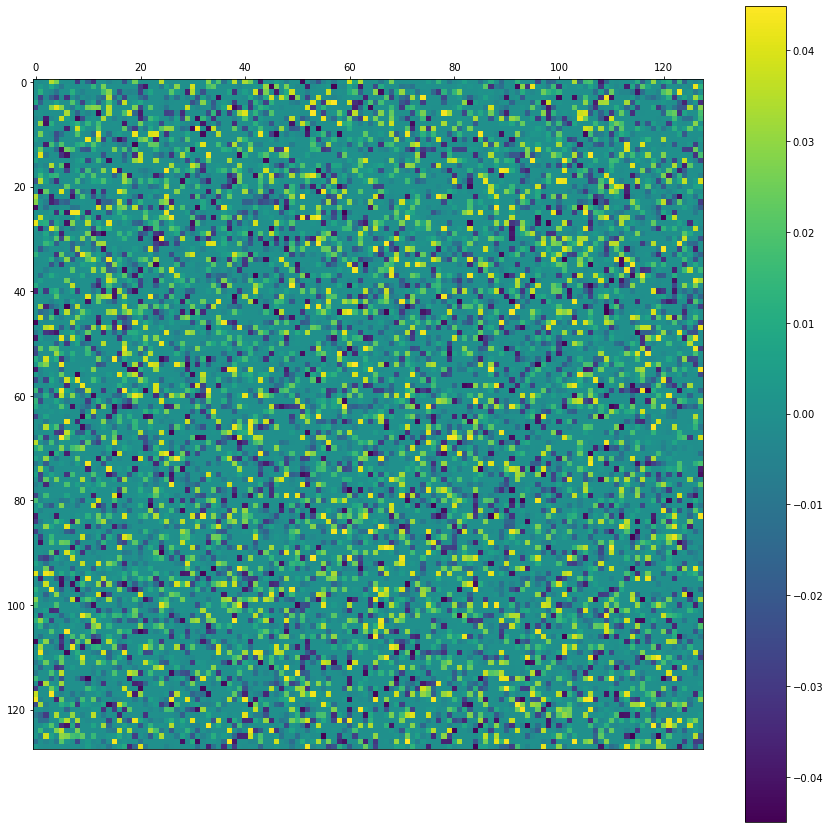

In [83]:
weights = []
for m in mod.t_encoder.layers[5].self_attn.modules():
    
    for p in m.named_parameters():
        
        weights.append(p)
        
print([(w[0],w[1].shape) for w in weights])
w = weights[2][1]

fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(w.detach().cpu().numpy())
ax.xaxis.tick_top()
plt.colorbar()
plt.savefig("colorbar.pdf")